In [10]:
import scipy.io
import numpy as np
import math
import cmath
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

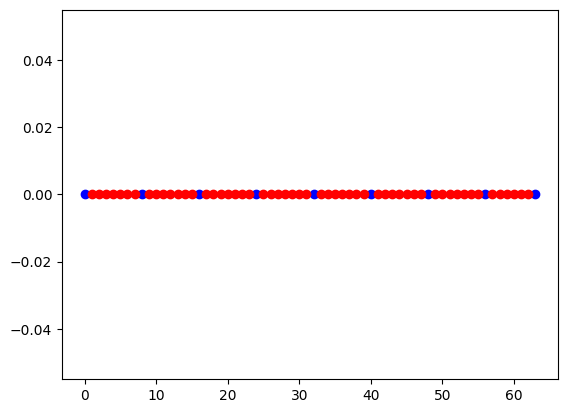

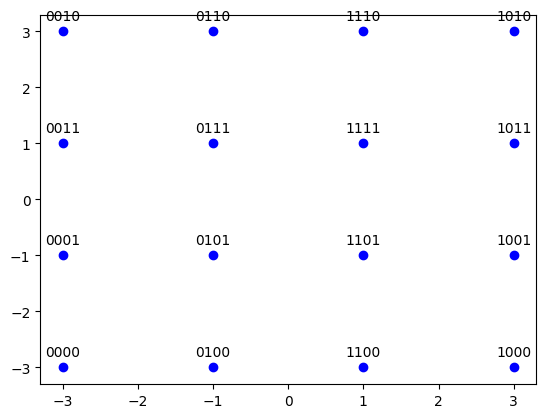

In [6]:
Num=64
CP=Num//4
L=3
P=8
pilotValue = 3+3j

allCarriers = np.arange(Num)
pilotCarriers = allCarriers[::Num//P]
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P=P+1
dataCarriers = np.delete(allCarriers, pilotCarriers)
#print ("allCarriers:   %s" % allCarriers)
#print ("pilotCarriers: %s" % pilotCarriers)
#print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.show()

M = 4
payloadBits_per_OFDM = len(dataCarriers)*M

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.show() 

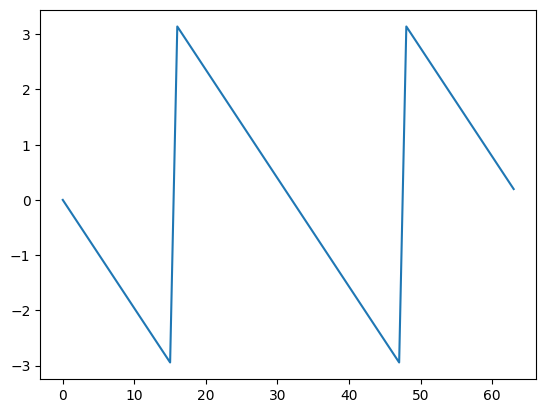

Bits count:  220
Mean:  1.0


In [46]:
demapping_table = {v : k for k, v in mapping_table.items()}
array=[]
for i in range(L):
    if i == 2:
        array.append(1)
    else:
        array.append(0)

channelResponse =array
H_exact = np.fft.fft(channelResponse, Num)
plt.plot(allCarriers, np.angle(H_exact/(2*math.pi)))
plt.show()
SNRdb = 20 

bits = np.random.binomial(n=1, p=1, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("Mean: ", np.mean(bits))

def SP(bits):
    return bits.reshape((len(dataCarriers), M))
bits_SP = SP(bits)

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(Num, dtype=complex)
    symbol[pilotCarriers] = pilotValue 
    symbol[dataCarriers] = QAM_payload
    return symbol
OFDM_data = OFDM_symbol(QAM)

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               
    return np.hstack([cp, OFDM_time]) 
OFDM_withCP = addCP(OFDM_time)

def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)


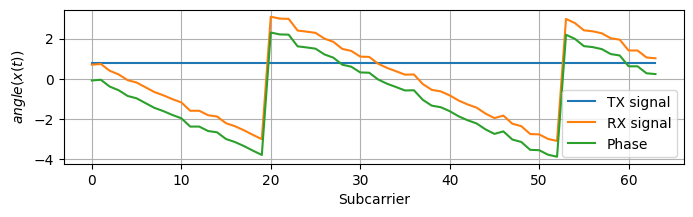

In [54]:
def removeCP(signal):
    return signal[CP:(CP+Num)]
OFDM_RX_noCP = removeCP(OFDM_RX)

plt.figure(figsize=(8,2))
plt.plot(np.angle(OFDM_data), label='TX signal')
plt.plot(np.angle(np.fft.fft(OFDM_RX_noCP)), label='RX signal')
plt.plot(np.angle(np.fft.fft(OFDM_RX_noCP))-np.angle(OFDM_data), label='Phase')
plt.legend(fontsize=10)
plt.xlabel('Subcarrier'); plt.ylabel('$angle(x(t))$');
plt.grid(True);
plt.show()

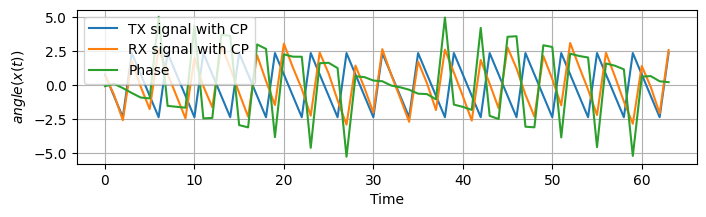

In [53]:
plt.figure(figsize=(8,2))
plt.plot(np.angle(np.fft.fft(OFDM_withCP,64)), label='TX signal with CP')
plt.plot(np.angle(np.fft.fft(OFDM_RX,64)), label='RX signal with CP')
plt.plot(np.angle(np.fft.fft(OFDM_RX,64))-np.angle(np.fft.fft(OFDM_withCP,64)), label='Phase')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$angle(x(t))$');
plt.grid(True);
plt.show()

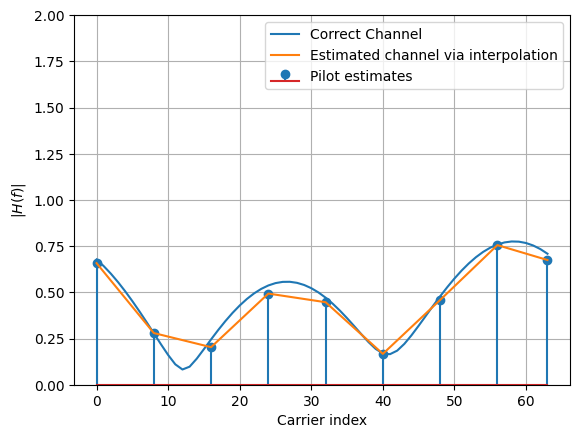

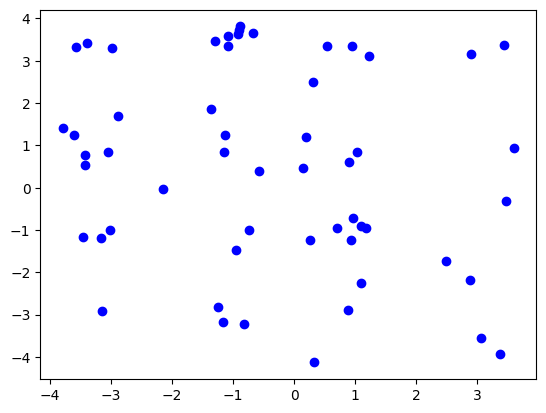

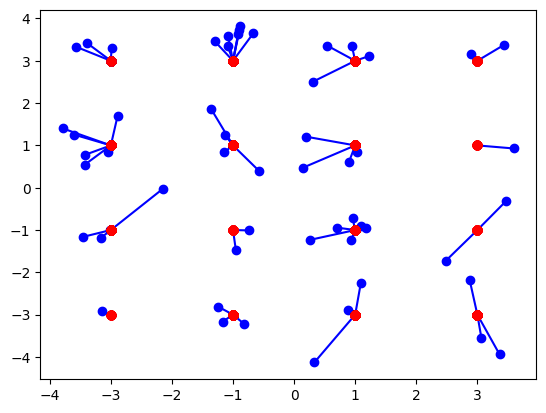

Obtained Bit error rate:  0.07727272727272727


In [8]:


def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    plt.show()
    return Hest
Hest = channelEstimate(OFDM_demod)

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');
plt.show()

def Demapping(QAM):
    constellation = np.array([x for x in demapping_table.keys()])
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    const_index = dists.argmin(axis=1)
    hardDecision = constellation[const_index]
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
plt.show()

def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))